In [13]:
import os
import math
import random
from typing import Tuple, List

import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

In [14]:
# Configuration
IMG_SIZE= 64
CHANNELS= 1
BATCH_SIZE= 64
Z_DIM= 100
LABEL_EMB_DIM= 50
NUM_EPOCHS= 40
LR= 2e-4
BETA1= 0.5
SAVE_DIR= "/content/drive/MyDrive/06-CGAN-shapes/cgan_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

LABELS = ["circle", "square", "triangle", "rectangle"]
NUM_CLASSES = len(LABELS)

In [15]:
# Draw Shapes

def draw_shape_image(label: str, size: int= IMG_SIZE):
  """Return a PIL grayscale image (size x size) with a centered shape (filled)."""
  img= Image.new("L", (size, size), color=0) # black background
  draw= ImageDraw.Draw(img)
  padding = size // 8
  left = padding
  top = padding
  right = size - padding
  bottom = size - padding

  if label == "square":
    draw.rectangle([left, top, right, bottom], fill=255)

  elif label == "rectangle":
    rect_right = left + int((right - left) * 1.5)   # wider than tall
    draw.rectangle([left, top, rect_right, bottom], fill=255)

  elif label == "circle":
    draw.ellipse([left, top, right, bottom], fill=255)

  elif label == "triangle":
    cx, cy = size / 2, size / 2
    h = (bottom - top)
    p1 = (cx, top)
    p2 = (left, bottom)
    p3 = (right, bottom)
    draw.polygon([p1, p2, p3], fill=255)

  else:
      raise ValueError("Unknown label")

  return img

In [16]:
# Dataset
class ShapesDataset(Dataset):
  def __init__(self, labels: List[str], dataset_size: int= 5000, transform=None):
    self.labels= labels
    self.dataset_size= dataset_size
    self.transform= transform

  def __len__(self):
    return self.dataset_size

  def __getitem__(self, idx):
    lab_idx= random.randrange(len(self.labels))
    lab= self.labels[lab_idx]
    img= draw_shape_image(lab, size= IMG_SIZE)
    if self.transform:
      img= self.transform(img)
    else:
       # convert to tensor in [0,1]
        arr = np.array(img, dtype=np.float32) / 255.0
       # shape to (C,H,W)
        arr = arr[None, :, :]  # grayscale -> channel 1
        img = torch.from_numpy(arr)
    label_tensor = torch.tensor(lab_idx, dtype=torch.long)
    return img, label_tensor


In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# Models
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant_(m.bias.data, 0)

In [19]:
class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_emb_dim=LABEL_EMB_DIM, num_classes=NUM_CLASSES, out_channels=CHANNELS):
        super().__init__()
        self.z_dim = z_dim
        self.label_emb = nn.Embedding(num_classes, label_emb_dim)

        input_dim = z_dim + label_emb_dim
        # project to a small spatial size then use ConvTranspose to upsample to 64x64
        self.net = nn.Sequential(
            # input is (input_dim)
            nn.Linear(input_dim, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(True),
            # reshape to (512, 4, 4)
            View((-1, 512, 4, 4)),
            # 8x upsampling twice -> 16,32,64
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, out_channels, 4, 2, 1, bias=False),  # 64x64
            nn.Sigmoid(),  # output in [0,1]
        )

    def forward(self, z, labels):
        # z: (B, z_dim); labels: (B,)
        le = self.label_emb(labels)  # (B, label_emb_dim)
        x = torch.cat([z, le], dim=1)
        x = self.net(x)
        return x

In [20]:
class Discriminator(nn.Module):
    def __init__(self, label_emb_dim=LABEL_EMB_DIM, num_classes=NUM_CLASSES, in_channels=CHANNELS):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, label_emb_dim)
        # We'll turn label embedding into a spatial map and concat as extra channels
        self.project_label = nn.Linear(label_emb_dim, IMG_SIZE * IMG_SIZE)

        self.net = nn.Sequential(
            # input channels = in_channels + 1 (label map)
            nn.Conv2d(in_channels + 1, 64, 4, 2, 1),   # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1), # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1), # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            View((-1, 512 * 4 * 4)),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid(),
        )

    def forward(self, imgs, labels):
        # imgs: (B, C, H, W)
        le = self.label_emb(labels)                 # (B, emb)
        label_map = self.project_label(le)          # (B, H*W)
        label_map = label_map.view(-1, 1, IMG_SIZE, IMG_SIZE)
        x = torch.cat([imgs, label_map], dim=1)     # (B, C+1, H, W)
        return self.net(x).view(-1)

class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape  # example (-1, 512, 4, 4)
    def forward(self, x):
        return x.view(*self.shape)

In [21]:
# Training
def train():
    # dataset
    ds = ShapesDataset(LABELS, dataset_size=12000)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

    G = Generator().to(DEVICE)
    D = Discriminator().to(DEVICE)
    G.apply(weights_init)
    D.apply(weights_init)

    criterion = nn.BCELoss()
    optimD = torch.optim.Adam(D.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimG = torch.optim.Adam(G.parameters(), lr=LR, betas=(BETA1, 0.999))

    fixed_z = torch.randn(NUM_CLASSES * 8, Z_DIM, device=DEVICE)
    fixed_labels = torch.tensor([i for i in range(NUM_CLASSES) for _ in range(8)], dtype=torch.long, device=DEVICE)

    print("Starting training on", DEVICE)
    step = 0
    for epoch in range(1, NUM_EPOCHS + 1):
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            bs = imgs.size(0)
            real = torch.ones(bs, device=DEVICE)
            fake = torch.zeros(bs, device=DEVICE)

            # Train Discriminator
            D.zero_grad()
            out_real = D(imgs, labels)
            loss_real = criterion(out_real, real)

            z = torch.randn(bs, Z_DIM, device=DEVICE)
            gen_imgs = G(z, labels)
            out_fake = D(gen_imgs.detach(), labels)
            loss_fake = criterion(out_fake, fake)

            lossD = (loss_real + loss_fake) * 0.5
            lossD.backward()
            optimD.step()

            # Train Generator
            G.zero_grad()
            out_fake2 = D(gen_imgs, labels)
            lossG = criterion(out_fake2, real)  # trick: want D to predict real for generated
            lossG.backward()
            optimG.step()

            if step % 200 == 0:
                print(f"Epoch[{epoch}/{NUM_EPOCHS}] Step:{step} LossD:{lossD.item():.4f} LossG:{lossG.item():.4f}")

            step += 1

        # Save sample images for each epoch
        with torch.no_grad():
            samples = G(fixed_z, fixed_labels).cpu()
            # make a grid: grouped by label
            save_image(samples, os.path.join(SAVE_DIR, f"epoch_{epoch:03d}.png"), nrow=8, normalize=False)
        # Save models
        torch.save({
            'G_state': G.state_dict(),
            'D_state': D.state_dict(),
            'optimG': optimG.state_dict(),
            'optimD': optimD.state_dict(),
            'epoch': epoch,
        }, os.path.join(SAVE_DIR, f"checkpoint_epoch_{epoch:03d}.pth"))

    print("Training finished.")

In [33]:
# Sampling helper
def generate_samples(model_path: str, output_path: str, label_strs: List[str], samples_per_label=8):
    device = DEVICE
    chk = torch.load(model_path, map_location=device)
    G = Generator().to(device)
    G.load_state_dict(chk['G_state'])
    G.eval()

    label_idxs = [LABELS.index(l) for l in label_strs]
    images = []
    z = torch.randn(len(label_idxs) * samples_per_label, Z_DIM, device=device)
    labels = []
    for idx in label_idxs:
        labels += [idx] * samples_per_label
    labels_t = torch.tensor(labels, dtype=torch.long, device=device)
    with torch.no_grad():
        gen = G(z, labels_t).cpu()
    # save grid
    save_dir= os.path.join(SAVE_DIR, "outputs")
    os.makedirs(save_dir, exist_ok=True)
    save_image(gen, os.path.join(save_dir, "samples.png"), nrow=samples_per_label, normalize=False)
    print("Saved generated samples to", os.path.join(save_dir, "samples.png"))

In [23]:
train()

Starting training on cuda
Epoch[1/40] Step:0 LossD:0.6593 LossG:11.4503
Epoch[2/40] Step:200 LossD:0.3045 LossG:0.3120
Epoch[3/40] Step:400 LossD:0.6856 LossG:0.4995
Epoch[4/40] Step:600 LossD:0.6571 LossG:0.3974
Epoch[5/40] Step:800 LossD:0.5991 LossG:1.0807
Epoch[6/40] Step:1000 LossD:0.6339 LossG:1.2632
Epoch[7/40] Step:1200 LossD:0.6502 LossG:0.9241
Epoch[8/40] Step:1400 LossD:0.6525 LossG:0.8296
Epoch[9/40] Step:1600 LossD:0.6657 LossG:0.7615
Epoch[10/40] Step:1800 LossD:0.6809 LossG:0.5576
Epoch[11/40] Step:2000 LossD:0.6950 LossG:0.5249
Epoch[12/40] Step:2200 LossD:0.7058 LossG:0.8389
Epoch[13/40] Step:2400 LossD:0.6856 LossG:0.5904
Epoch[14/40] Step:2600 LossD:0.6933 LossG:0.7255
Epoch[15/40] Step:2800 LossD:0.6854 LossG:0.7688
Epoch[17/40] Step:3000 LossD:0.6869 LossG:0.7481
Epoch[18/40] Step:3200 LossD:0.6886 LossG:0.7608
Epoch[19/40] Step:3400 LossD:0.6892 LossG:0.7621
Epoch[20/40] Step:3600 LossD:0.6932 LossG:0.7886
Epoch[21/40] Step:3800 LossD:0.6920 LossG:0.7906
Epoch[22/

In [34]:
# Define save dir for generated samples
sample_dir = os.path.join(SAVE_DIR, "outputs")
# Example: generate images from a trained checkpoint
generate_samples(
    model_path="/content/drive/MyDrive/06-CGAN-shapes/cgan_checkpoints/checkpoint_epoch_040.pth",  # use the last one, or whichever epoch you want
    output_path="/content/drive/MyDrive/06-CGAN-shapes/outputs",
    label_strs=["circle", "square", "triangle", "rectangle"],
    samples_per_label=8
)

Saved generated samples to /content/drive/MyDrive/06-CGAN-shapes/cgan_checkpoints/outputs/samples.png


In [28]:
import os
print(os.listdir("/content/drive/MyDrive/06-CGAN-shapes/cgan_checkpoints"))

['epoch_001.png', 'checkpoint_epoch_001.pth', 'epoch_002.png', 'checkpoint_epoch_002.pth', 'epoch_003.png', 'checkpoint_epoch_003.pth', 'epoch_004.png', 'checkpoint_epoch_004.pth', 'epoch_005.png', 'checkpoint_epoch_005.pth', 'epoch_006.png', 'checkpoint_epoch_006.pth', 'epoch_007.png', 'checkpoint_epoch_007.pth', 'epoch_008.png', 'checkpoint_epoch_008.pth', 'epoch_009.png', 'checkpoint_epoch_009.pth', 'epoch_010.png', 'checkpoint_epoch_010.pth', 'epoch_011.png', 'checkpoint_epoch_011.pth', 'epoch_012.png', 'checkpoint_epoch_012.pth', 'epoch_013.png', 'checkpoint_epoch_013.pth', 'epoch_014.png', 'checkpoint_epoch_014.pth', 'epoch_015.png', 'checkpoint_epoch_015.pth', 'epoch_016.png', 'checkpoint_epoch_016.pth', 'epoch_017.png', 'checkpoint_epoch_017.pth', 'epoch_018.png', 'checkpoint_epoch_018.pth', 'epoch_019.png', 'checkpoint_epoch_019.pth', 'epoch_020.png', 'checkpoint_epoch_020.pth', 'epoch_021.png', 'checkpoint_epoch_021.pth', 'epoch_022.png', 'checkpoint_epoch_022.pth', 'epoch_02

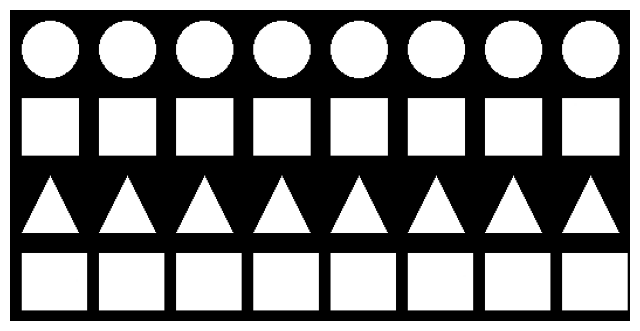

In [36]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to your generated sample
sample_path = "/content/drive/MyDrive/06-CGAN-shapes/cgan_checkpoints/outputs/samples.png"

# Open and display
img = Image.open(sample_path)
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()